In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.decomposition import PCA
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

import os
import re
import itertools

import cv2

%matplotlib inline

# Final Project
<br>Derek Halliwell
<br>Holden Gordon
<br>ELEN 520: Spring 2019


**1. Devise a hypothesis and state the relevant null and alternative hypothesis.**
<br>H0: Image pixel values are not correlated with the year of the coin
<br>H1: Image pixel values are correlated with the year of the coin

**2. Design an experiment to test your hypothesis with predictors X1, X2, ..,Xn and response Y. Set up your experiment using two or more sensors with the PYNQ board. Collect data from the sensors and store in a CSV file. Decide the number of observations and duration over which the data will be collected.**
<br>We will attempt to extract the year of a U.S. penny from coin images. The training data will be collected from coin websites. Test data will be generated by a camera connected to the PYNQ board.


# Load Data

In [107]:
def file_format(f):
    if f.endswith('.png'):
        return 'PNG'
    if f.endswith('.jpg'):
        return 'JPEG'
    else:
        return 'other'


train_filenames = []
test_filenames = []

for f in os.listdir(os.getcwd() + '/all_coins'):
    if f.endswith('.png') | f.endswith('.jpg'):
        train_filenames.append(f)
    if f.endswith('.JPG'):
        test_filenames.append(f)

train = pd.DataFrame({'filename':train_filenames})
test = pd.DataFrame({'filename':test_filenames})

train['dataset'] = 'train'
test['dataset'] = 'test'

coins = pd.concat([train,test],ignore_index=True)

coins['file_format'] = coins['filename'].apply(lambda f: file_format(f))
# coins['source'] = coins['filename'].apply(lambda f: f.split('_')[0].upper())

coins.info()
coins.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 3 columns):
filename       883 non-null object
dataset        883 non-null object
file_format    883 non-null object
dtypes: object(3)
memory usage: 20.8+ KB


,filename,dataset,file_format
0,ec_1928_D_BBSC21064.png,train,PNG
1,ct_1945_S.png,train,PNG
2,ec_1944_P_CLS030.png,train,PNG


In [108]:
coins.file_format.value_counts()

PNG      619
JPEG     235
other     29
Name: file_format, dtype: int64

In [109]:
print('Image Count:',coins.filename.nunique()) 
print('Digit count:',coins.filename.nunique()*4)

Image Count: 883
Digit count: 3532


In [110]:
coins.head()

,filename,dataset,file_format
0,ec_1928_D_BBSC21064.png,train,PNG
1,ct_1945_S.png,train,PNG
2,ec_1944_P_CLS030.png,train,PNG
3,ct_1945_D.png,train,PNG
4,ngc_1959_D.jpg,train,JPEG


In [111]:
def find_year(s):
    year_search = re.search('\d{4}', s)
    
    if year_search is not None:
        return year_search.group(0)
    return '0'

coins['year_str'] = coins['filename'].apply(lambda x: find_year(x))
coins['year'] = coins['year_str'].astype(int)

midpoint_year = int( (coins['year'].min() + coins['year'].max()) ) / 2 # returns 1963
coins['after_1962'] = (midpoint_year < coins['year']).astype(int)
coins['after_1962_str'] = coins['after_1962'].apply(lambda x: 'Yes' if x else 'No')

# Create cv2 image objects
coins['img'] = coins['filename'].apply(lambda filename: cv2.imread('all_coins/' + filename,0))

# cv2 image attributes
coins['height'] = coins['img'].apply(lambda img: img.shape[0])
coins['width'] = coins['img'].apply(lambda img: img.shape[1])
coins['size'] = coins['img'].apply(lambda img: img.size)
coins['dtype'] = coins['img'].apply(lambda img: img.dtype)

coins.head(2)

,filename,dataset,file_format,year_str,year,after_1962,after_1962_str,img,height,width,size,dtype
0,ec_1928_D_BBSC21064.png,train,PNG,1928,1928,0,No,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",150,150,22500,uint8
1,ct_1945_S.png,train,PNG,1945,1945,0,No,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",197,200,39400,uint8


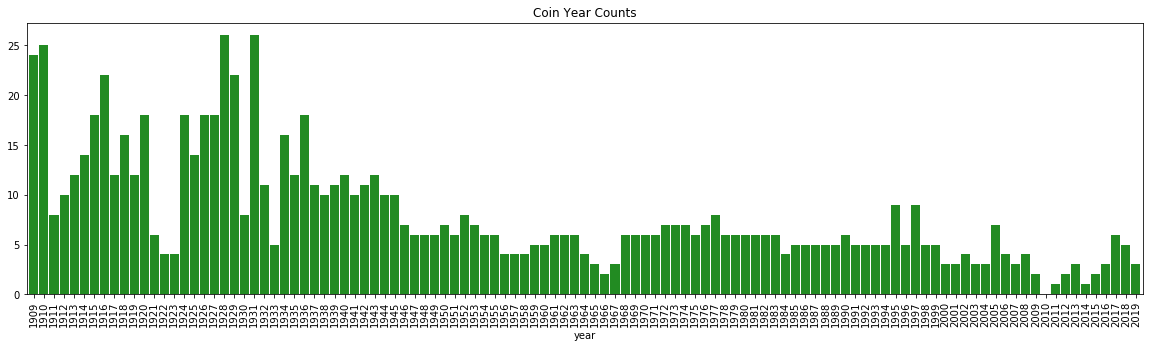

In [112]:
year_counts = pd.DataFrame(coins['year'].value_counts())
year_counts = year_counts.rename({'year':'count'},axis=1)

years = list(range(1909,2019+1))

counts = pd.DataFrame({'year':years})
counts = counts.set_index('year')

counts = counts.merge(year_counts,how='left',left_index=True,right_index=True)

counts.plot.bar(figsize=(20,5),
                title='Coin Year Counts',
                legend=False,
                color='forestgreen',width=0.9);

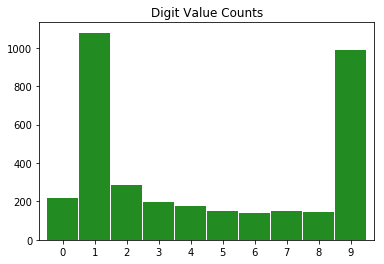

In [113]:
chars = []

for year in coins['year_str']:
    for char in year:
        chars.append(int(char))

digits = pd.Series(chars).value_counts().sort_index()
        
digits.plot.bar(rot=0,
                color='forestgreen',
                width=0.97,
                title='Digit Value Counts');

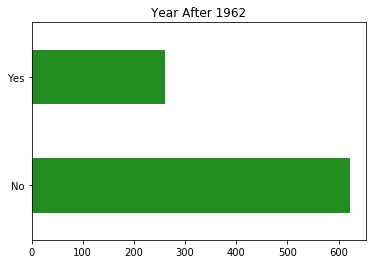

In [114]:
coins['after_1962_str'].value_counts().plot.barh(color='forestgreen',title='Year After 1962');

# Preprocessing

In [115]:
# Demonstrate preprocessing on these 5 images (see below)
samples = coins['img'].sample(3)

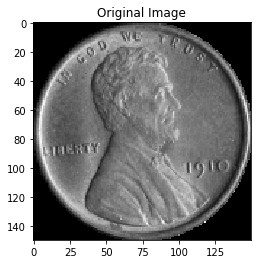

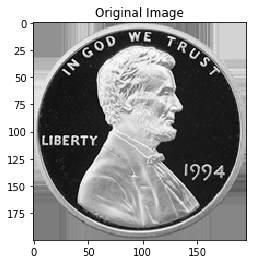

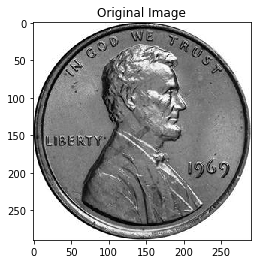

In [116]:
for img in samples:
    # plot 5 sample images
    plt.imshow(img,cmap='gray');
    plt.title('Original Image')
    plt.show();

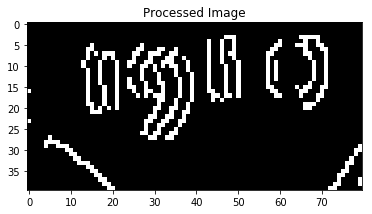

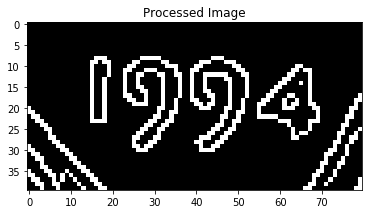

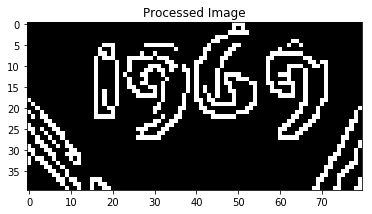

In [117]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged


def preprocess(img):
    """
    Performs following image processing steps:
    1. Resize image to 290 x 290
    2. Apply gaussian blur
    3. Apply canny edge detection
    4. Slice image to only contain year string
    
    """
    width = 290
    height = 290
    midpoint = int(width/2)
    
    
    output = img.copy()
    
    # Resize images to 150
    width = 290
    height = 290
    output = cv2.resize(output,(width,height)) 

    # Noise reduction
    blurred = cv2.GaussianBlur(output, (3, 3), 0)
    
    # Canny Edge Detection
    output = auto_canny(blurred)
    
    # Keep bottom right quadrant of image
    output = output[midpoint+35:-70,midpoint+45:-20]
    
    return output

for img in samples:
    # plot 5 sample images
    p = preprocess(img)
    
    plt.imshow(p,cmap='gray');
    plt.title('Processed Image')
    plt.show();

In [118]:
# Apply to all images
coins['canny'] = coins['img'].apply(lambda img: preprocess(img))

# Classification

In [119]:
len(coins)

883

In [120]:
# Convert array of images to array of 1d lists
img_lists = coins['canny'].apply(lambda x: x.reshape(np.product(x.shape)).tolist()).values.tolist()

X = pd.DataFrame(img_lists, index=coins.index)

# Convert to binary
X[X==255] = 1

X = X.merge(coins[['dataset','after_1962']],how='inner',left_index=True,right_index=True)
y = X['after_1962']

X_train = X[X.dataset == 'train']
X_test = X[X.dataset == 'test']

X_train_index = X_train.index
X_test_index = X_test.index

y_train = X_train['after_1962']
y_test = X_test['after_1962']

X_train = X_train.drop(['dataset','after_1962'],axis=1)
X_test = X_test.drop(['dataset','after_1962'],axis=1)
X = X.drop(['dataset','after_1962'],axis=1)

# Oversample minority class
max_count = y_train.value_counts().max()
sampling_strategy = {0:max_count,1:max_count}

ros = RandomOverSampler(sampling_strategy=sampling_strategy,
                        random_state=2019)

print(X_train.shape)
X_train, y_train = ros.fit_resample(X_train,y_train)
print(X_train.shape)

(854, 3200)
(1244, 3200)


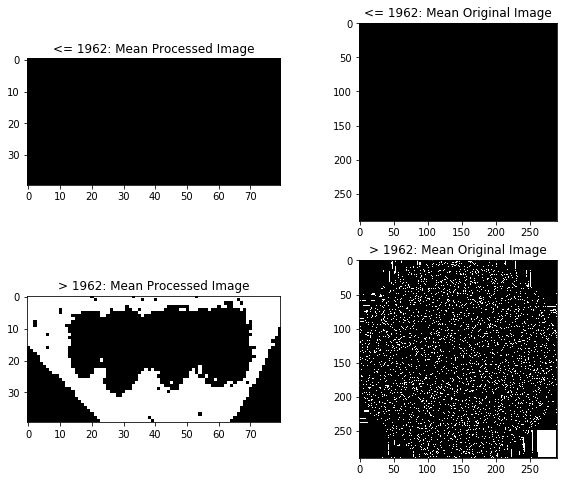

In [121]:
# Plot average original and preprocessed images for each class
fig,ax = plt.subplots(2,2,figsize=(10,8))

ax = ax.flatten()

before = coins[(coins['after_1962'] == 0) & (coins['dataset'] == 'train')]
after = coins[(coins['after_1962'] == 1) & (coins['dataset'] == 'train')]

avg_before_canny = (before['canny'].mean()).astype(int)
avg_before_img = (before['img'].apply(lambda x: cv2.resize(x,(290,290))).mean()).astype(int)

avg_after_canny = (after['canny'].mean()).astype(int)
avg_after_img = (after['img'].apply(lambda x: cv2.resize(x,(290,290))).mean()).astype(int)

ax[0].imshow(avg_before_canny,cmap='gray')
ax[0].title.set_text('<= 1962: Mean Processed Image')

ax[1].imshow(avg_before_img,cmap='gray')
ax[1].title.set_text('<= 1962: Mean Original Image')

ax[2].imshow(avg_after_canny,cmap='gray')
ax[2].title.set_text('> 1962: Mean Processed Image')

ax[3].imshow(avg_after_img,cmap='gray')
ax[3].title.set_text('> 1962: Mean Original Image')

plt.show()

These graphs tell us that the photos of older penny images are significantly darker. This will significantly impact our classification efforts.

**3. Fit the data to two different models.**

In [122]:
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train,y_train);

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train,y_train);

**4. Compute the LOOCV errors from fitting the two models.**

In [14]:
# Calculate LOOCV accuracy
loo = LeaveOneOut()
loo_scores_rf = []
loo_scores_lr = []

for train_index, test_index in loo.split(X_train):
    X_tr, X_tst = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_tst = y_train.iloc[train_index], y_train.iloc[test_index]
    
    log_reg.fit(X_tr,y_tr)
    forest.fit(X_tr,y_tr)
    
    y_preds_lr = log_reg.predict(X_tst)
    y_preds_rf = forest.predict(X_tst)
    
    loo_scores_rf.append(accuracy_score(y_tst, y_preds_lr))
    loo_scores_lr.append(accuracy_score(y_tst, y_preds_rf))

LOOCV_rf = np.mean(loo_scores_rf)
print('LOOCV_rf',LOOCV_rf)

LOOCV_lr = np.mean(loo_scores_lr)
print('LOOCV_lr',LOOCV_lr)

LOOCV_rf 0.9426229508196722
LOOCV_lr 0.8981264637002342


**5. Obtain the estimate for the test error using K-fold cross validation. What value of K did you choose and why? How does this test error compare with the LOOCV error?**

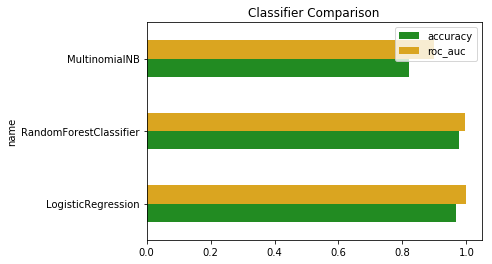

In [123]:
# Cross Validation Scores
clfs = [LogisticRegression(solver='lbfgs'),
        RandomForestClassifier(n_estimators=100),
        MultinomialNB()]

accuracy_scores = []
roc_scores = []
names = []

for clf in clfs:
    name = clf.__class__.__name__
    names.append(name)
    
    acc = np.mean(cross_val_score(clf,X_train,y_train,scoring='accuracy',cv=5))
    accuracy_scores.append(acc)
    
    roc = np.mean(cross_val_score(clf,X_train,y_train,scoring='roc_auc',cv=5))
    roc_scores.append(roc)
    
scores = pd.DataFrame({'name':names,'accuracy':accuracy_scores,'roc_auc':roc_scores})
scores = scores.set_index('name',drop=True)

scores.plot.barh(title='Classifier Comparison',color=['forestgreen','goldenrod']);

In [124]:
scores

,accuracy,roc_auc
name,,
LogisticRegression,0.967071,0.997560
RandomForestClassifier,0.976761,0.996153
MultinomialNB,0.821548,0.898377


We chose 5 folds because we don't have very many observations.

**6. Create the following diagnostic plots of the linear regression fit:
 (a) Influence plot
 (b) Pairwise plot
 (c) Studentized residual vs predicted response
 (d) QQ plot for residuals
Are there any problems with the fit? Are there any unusually large outliers? Are there any
observations with unusually high leverage? Is there a non-linear association between any of the
predictors and response? Is heteroscedasticity present in the model?**

Having binary data, the biggest issue is having columns with no variance.

In [133]:
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train,y_train);

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train,y_train);

y_preds = forest.predict(X_test)

# Plot normalized confusion matrix
cm = confusion_matrix(y_preds,y_test)

print('Test Size:',len(y_test))

pd.DataFrame(cm,
             index=['Pred = 0','Pred = 1'],
             columns=['Actual = 0','Actual = 1'])

Test Size: 29


,Actual = 0,Actual = 1
Pred = 0,1,25
Pred = 1,0,3


In [134]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.04      1.00      0.07         1
           1       1.00      0.11      0.19        28

   micro avg       0.14      0.14      0.14        29
   macro avg       0.52      0.55      0.13        29
weighted avg       0.97      0.14      0.19        29



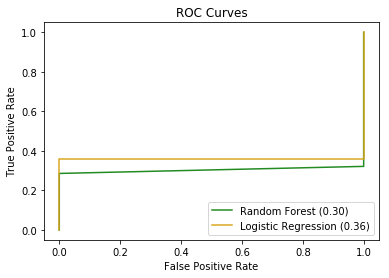

In [135]:
y_pred_proba_rf = forest.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test,  y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

y_pred_proba_lr = log_reg.predict_proba(X_test)[::,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test,  y_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

plt.plot(fpr_rf,tpr_rf,label='Random Forest ({0:.2f})'.format(auc_rf),c='forestgreen')
plt.plot(fpr_lr,tpr_lr,label='Logistic Regression ({0:.2f})'.format(auc_lr),c='goldenrod')
plt.legend(loc=4)
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**7. Compare the correlation matrix of the predictor variables and the corresponding scatter plot
matrix. Do you see any evidence of collinearity?**

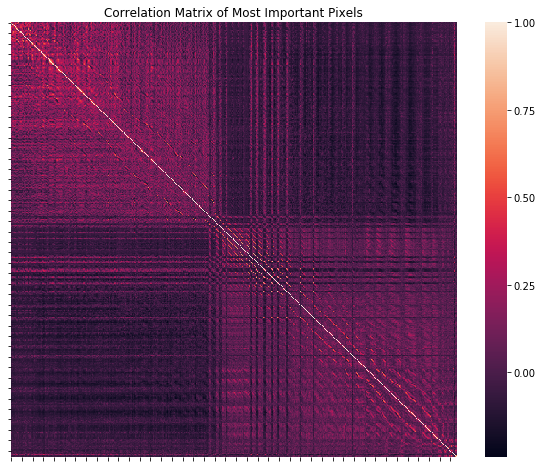

In [138]:
# Since we have thousands of columns, I will select the top 500 columns
kbest = SelectKBest(chi2, k=500)

kbest.fit(X_train,y_train)

X_kbest = kbest.transform(X_train)

fig,ax = plt.subplots(1,1, figsize = (10,8))

sns.heatmap(pd.DataFrame(X_kbest).corr());
ax.set_xticklabels('');
ax.set_yticklabels('');
ax.set_title('Correlation Matrix of Most Important Pixels');

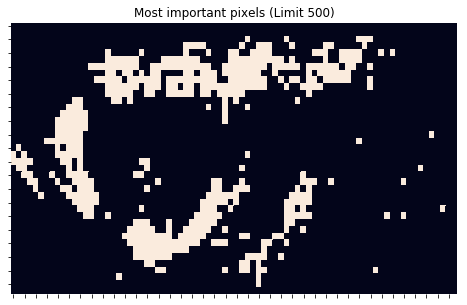

In [139]:
kbest_indices = kbest.get_support().astype(int)

fig,ax = plt.subplots(1,1, figsize = (8,5))

ax = sns.heatmap(kbest_indices.reshape(coins['canny'][0].shape),cbar=False);
ax.set_xticklabels('');
ax.set_yticklabels('');
ax.set_title('Most important pixels (Limit 500)');


**8. Compute the corresponding principal components, their sample variances and the condition number. How many different sets of collinearity exist in the data? What variables are involved in each set?**



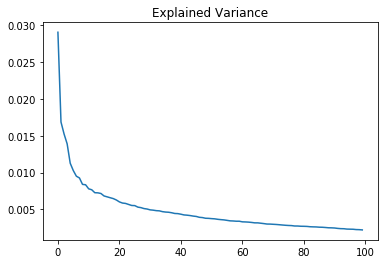

In [140]:
# PCA to visualize collinearity
pca = PCA(n_components=100)
pca.fit(X)

plt.plot(pca.explained_variance_ratio_);
plt.title('Explained Variance');

I would choose 15 components in the data.

In [141]:
# Condition Number
eigenvalues = pca.explained_variance_
cond = np.max(eigenvalues)/np.min(eigenvalues)
cond

13.2193133994839

There is significant collinearity in the data. This could be due to many of the pixel columns not having any variance at all.

**9. Based on the number of PCs you choose to retain, obtain the PC estimates of the coefficients.**



In [142]:
n_components = 15

pca = PCA(n_components=n_components)

X_pca = pd.DataFrame(pca.fit_transform(X),index=X.index)
X_pca.shape

(883, 15)

In [143]:
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_pca.iloc[X_train_index],y.iloc[X_train_index]);

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_pca.iloc[X_train_index],y.iloc[X_train_index]);

y_preds = forest.predict(X_pca.iloc[X_test_index])

# Plot normalized confusion matrix
cm = confusion_matrix(y_preds,y_test)

print('Test Size:',len(y_test))

pd.DataFrame(cm,
             index=['Pred = 0','Pred = 1'],
             columns=['Actual = 0','Actual = 1'])

Test Size: 29


,Actual = 0,Actual = 1
Pred = 0,1,28
Pred = 1,0,0


**10. Using the ridge method, construct the ridge trace. What value of k to you recommend for
estimation of parameters. Compute the ridge estimates of the regression coefficients using
this value of k.**

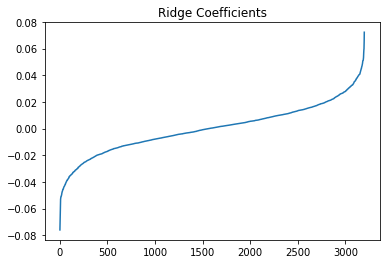

In [144]:
ridge = RidgeClassifier()

ridge.fit(X_train,y_train)

plt.plot(sorted(ridge.coef_[0]));
plt.title('Ridge Coefficients');

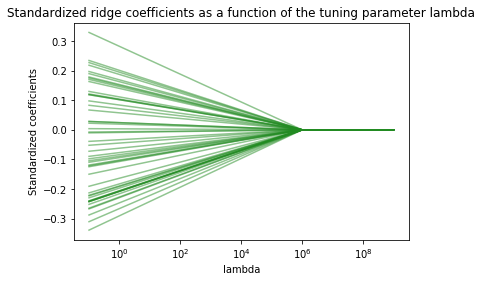

In [148]:
# Ridge Trace
k = 50
coefs_pixels = [[] for _ in range(k)]

kbest = SelectKBest(chi2, k=k)
kbest.fit(X_train,y_train)
X_kbest = kbest.transform(X_train)

X_train_ridge, X_test_ridge , y_train_ridge, y_test_ridge = train_test_split(X_kbest,
                                                                             y_train,
                                                                             test_size=0.5,
                                                                             random_state=1)

lambda_ = np.linspace(10**-1, 10**9,1000)

for a in lambda_:
    ridge.set_params(alpha=a)
    ridge.fit(X_train_ridge, y_train_ridge) # fit to model
    
    for i in range(k):
        coefs_pixels[i].append(ridge.coef_[0][i])
    
fig, ax = plt.subplots()
       
for i in range(k):
    plt.plot(lambda_, coefs_pixels[i], linestyle = "-",c='forestgreen',alpha=0.5)
                        
                        
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)
                        
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('Standardized coefficients')
plt.title('Standardized ridge coefficients as a function of the tuning parameter lambda');

Since we don't see a converge until large values of k, I would choose k > 10^5. 